<h1>Cyclotron emission equations from Chanmugam and Dulk 1981</h1>
<h2>Code written by N. Zakamska, 2022. If you use this code, please cite <a href="https://ui.adsabs.harvard.edu/abs/2022arXiv221114945L/abstract">Liu et al.</a></h2>
<h3><font color="ff0000">The shape of the features seems to be in agreement with works published by Schwope, except possibly in the high-temperature regime. The overall SED shape deviates from published work (mine tends to peak at shorter wavelengths). If you find a mistake, please email me as soon as possible.</font></h3>


In [1]:
from __future__ import print_function
import numpy as np
from scipy import special
from IPython.display import Image

from os import path
import os
import sys

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

#sys.path.append("/Users/nadia/mypython/")
#sys.path.append("/Users/nadia/mypython/wdtools")
#import nadia
#import wdtools

###Plot formatting commands
plt.rc('figure', figsize=(10.0, 7.1)) #bigger figures
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif','size':20, 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands


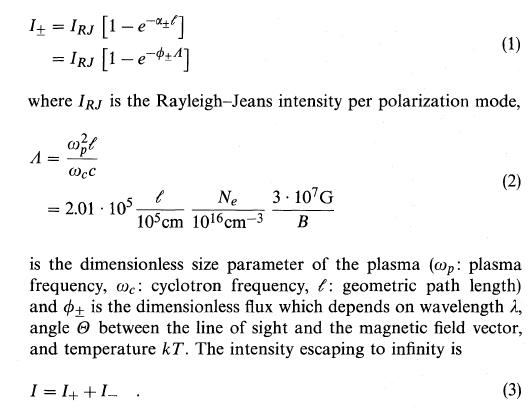

In [37]:
Image(filename='pic/schwope_1990_pic1.jpg', width=500)
# https://ui.adsabs.harvard.edu/abs/1990A%26A...230..120S/abstract

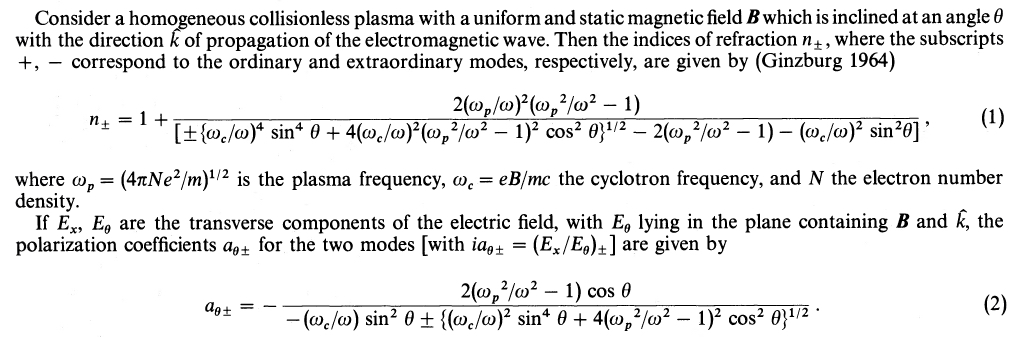

In [38]:
Image(filename='pic/chan_1981_pic1.jpg')
# https://ui.adsabs.harvard.edu/abs/1981ApJ...244..569C/abstract

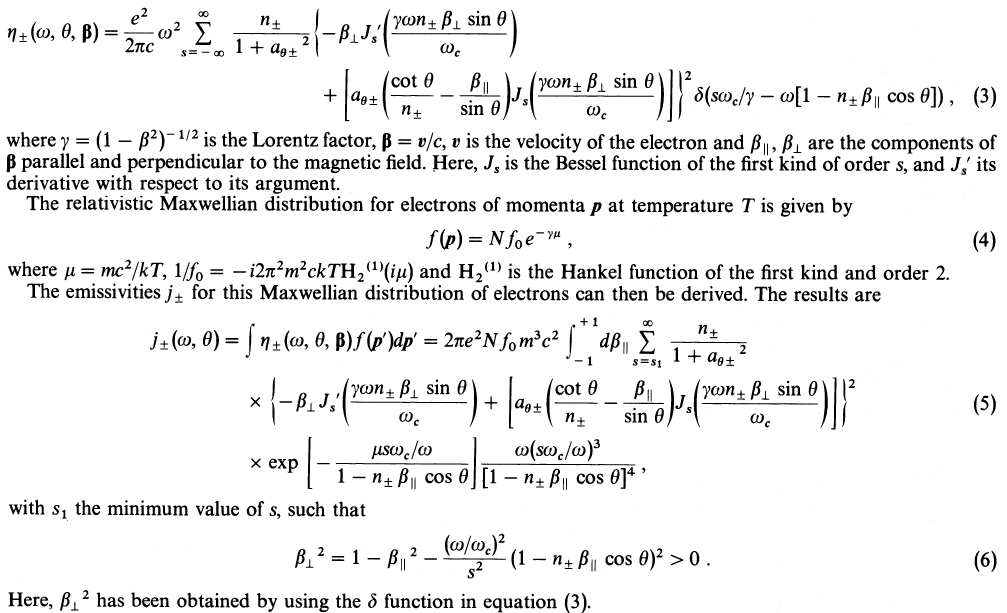

In [39]:
Image(filename='pic/chan_1981_pic2.jpg')
# https://ui.adsabs.harvard.edu/abs/1981ApJ...244..569C/abstract

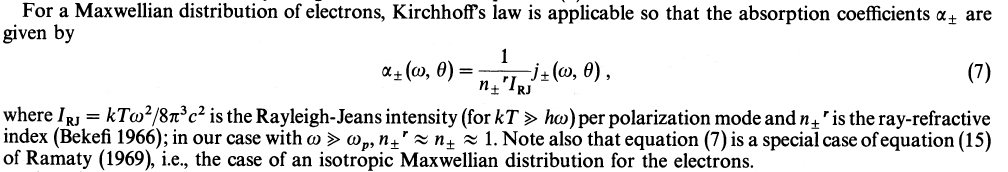

In [40]:
Image(filename='pic/chan_1981_pic3.jpg')
# https://ui.adsabs.harvard.edu/abs/1981ApJ...244..569C/abstract

In [6]:
# First we will need to have Bessel functions and their derivatives
#https://proofwiki.org/wiki/Series_Expansion_of_Bessel_Function_of_the_First_Kind
import math
def BesselJ(s,x,tol=1e-14):
    # this is working, but unnecessary, I am using the special function from SciPy
    total=0.0
    k=0
    term=(-1)**k*1.0/(math.factorial(k)*math.factorial(int(s)+k))*(x/2)**(int(s)+2*k)
    while (max(abs(term))>tol):
        total=total+term
        k=k+1
        term=(-1)**k*1.0/(math.factorial(k)*math.factorial(int(s)+k))*(x/2)**(int(s)+2*k)
    return(total)
def BesselJPrime(s,x):
    #https://functions.wolfram.com/Bessel-TypeFunctions/BesselJ/20/ShowAll.html  
    return(s/x*special.jv(s,x)-special.jv(s+1, x))
# if needed, the derivative can be re-written in terms of the series to avoid divergence
# at zero, but it seems that we never hit zero
# there is also an approximation to the Bessel function in Meggitt, but it seems unnecessary?..

<ipython-input-6-1bad96c6f284>:16: RuntimeWarning: divide by zero encountered in true_divide
  return(s/x*special.jv(s,x)-special.jv(s+1, x))
<ipython-input-6-1bad96c6f284>:16: RuntimeWarning: invalid value encountered in multiply
  return(s/x*special.jv(s,x)-special.jv(s+1, x))


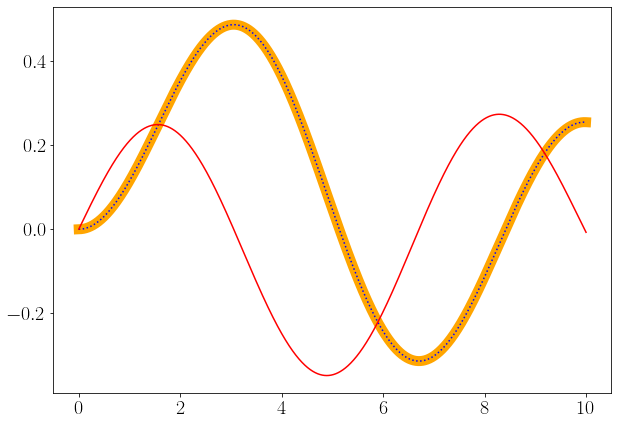

In [7]:
# let's make sure this is all looking healthy
x=np.arange(0,10,0.001)
plt.plot(x,BesselJ(2,x),color='orange',linewidth=10)
plt.plot(x,special.jv(2, x), color='blue', linestyle='dotted')
plt.plot(x,BesselJPrime(2,x), color='red')
#OK, my series agrees with the special function and the derivative seems reasonable
# there is a problem at x=0 for the Bessel function derivative, but it doesn't look like we encounter it in the 
# actual code

In [8]:
# fundamental constants
Msun=2e33
year=3.14e7
mp=1.67e-24
qe=4.8e-10
me=9.1e-28
c=3e10
keV=1e3*1.6e-12

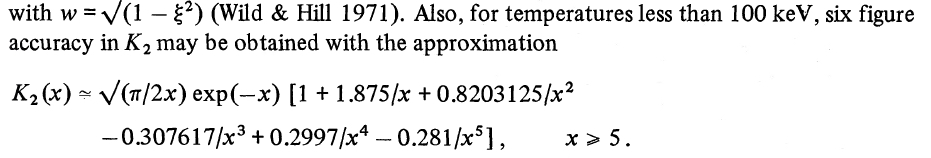

In [50]:
Image(filename='pic/meggitt_1982_pic2.jpg')
# https://ui.adsabs.harvard.edu/abs/1982MNRAS.198...71M/abstract

In [9]:
def ComputeSpec(myomega, kT, B, theta, loglam):
    #
    # arguments:
    # myomega is a numpy array of angular frequencies at which to calculate the output spectrum, in cgs units
    # kT is the electron temperature, in cgs units
    # B is the magnetic field, in cgs units
    # theta is the observer's angle, in radians
    # loglam is the log-base-10 of the dimensionless column density parameter 
    # Lambda = omega_p^2 length / (omega_c c), where omega_p is the plasma frequency, length is the path length
    # through the emitting plasma, omega_c is the cyclotron frequency
    #
    # output: 
    # intensity of emission per unit angular frequency in cgs units
    
    # We are going to explicitly assume that omega_p=0 and therefore that index of refraction is exactly 1. 
    omega_c=qe*B/(me*c)
    mu=me*c**2/kT
    def MeggittK2(x):
        # Chanmugam and Dulk 1981 give the normalization of the distribution function in terms of the 
        # impenetrable Hankel functions of the second kind of a purely imaginary argument. It can be 
        # re-written in terms of K_2, the modified Bessel function of the 2nd kind. 
        # This expansion (above) is from Meggitt and Wickramasinghe 1982, which is similar to
        # but not quite the same as the series expansion of the Hankel function from
        # here: https://dlmf.nist.gov/10.17, differing with it in the last two terms, which is 
        # apparently a better approximation to the Bessel function of the second kind or the Hankel
        # function of the second kind in the range of mu between 5 and 10, which I've verified in 
        # Mathematica
        # but honestly this probably doesn't matter because the overall normalization doesn't seem to be used
        # very often (or at all), with most published model spectra "arbitrarily normalized"
        return(1. + 1.875/x + 0.8203125/x**2 - 0.307617/x**3 + 0.2997/x**4 - 0.281/x**5)
    f0=np.exp(mu)*(2*np.pi*me*kT)**(-1.5)/MeggittK2(mu)
    mylam=10**loglam

    def Atheta(omega, omega_c, theta, pm):
        numer=2*np.cos(theta)
        denom=-omega_c/omega*np.sin(theta)**2+pm*np.sqrt((omega_c/omega*np.sin(theta)**2)**2+4*np.cos(theta)**2)
        return(numer/denom)
    def Smin(omega, omega_c, theta, beta_par):
        return(np.floor(omega*(1-beta_par*np.cos(theta))/(omega_c*np.sqrt(1-beta_par**2)))+1.)
    def BetaPerp(omega, omega_c, theta, beta_par, s):
        return(np.sqrt(1-beta_par**2-(omega/(omega_c*s))**2*(1-beta_par*np.cos(theta))**2))
    def Integrand(omega, omega_c, theta, pm, beta_par, s):
        term1=1./(1+Atheta(omega,omega_c,theta,pm)**2)
        beta_perp=BetaPerp(omega, omega_c, theta, beta_par, s)
        Lorentz=1./np.sqrt(1-beta_par**2-beta_perp**2)
        arg=Lorentz*omega*beta_perp*np.sin(theta)/omega_c
        term2a=-beta_perp*BesselJPrime(s,arg)
        term2b=Atheta(omega,omega_c,theta,pm)*(np.cos(theta)-beta_par)/np.sin(theta)*special.jv(s,arg)
        term3=np.exp(-mu*s*omega_c/(omega*(1-beta_par*np.cos(theta))))
        term4=omega*(s*omega_c/omega)**3/(1-beta_par*np.cos(theta))**4
        return(term1*(term2a+term2b)**2*term3*term4)
    def Integral(omega, omega_c, theta, pm, delta_b=0.001, delta_s=10):
        # the convergence has been tested with delta_b=0.01, 0.001 and 0.0001 
        # and delta_s=10 and 20
        beta_par=np.linspace(-1.+delta_b/2.,1-delta_b/2.,int(2./delta_b))
        mysmin=Smin(omega, omega_c, theta, beta_par)
        total=Integrand(omega, omega_c, theta, pm, beta_par, mysmin)
        for ds in range(1,delta_s+1):
            total+=Integrand(omega, omega_c, theta, pm, beta_par, mysmin+ds)
        return(np.sum(delta_b*total))
    def IRJ(omega):
        return(kT*omega**2/(8*np.pi**3*c**2))
    def Phi(omega, omega_c, theta, pm):
        numer=f0*me**4*c**3*omega_c*Integral(omega, omega_c, theta, pm)
        denom=2*IRJ(omega)
        return(numer/denom)
    def Inten(omega, omega_c, theta):
        term1=-Phi(omega,omega_c, theta, 1.)*mylam
        term2=-Phi(omega,omega_c, theta, -1.)*mylam
        return(IRJ(omega)*(2.-np.exp(term1)-np.exp(term2)))

    myinten=np.zeros(len(myomega))
    for i, omega in enumerate(myomega):
        myinten[i]=Inten(omega, omega_c, theta)
    return(myinten)

<h1>First test</h1>

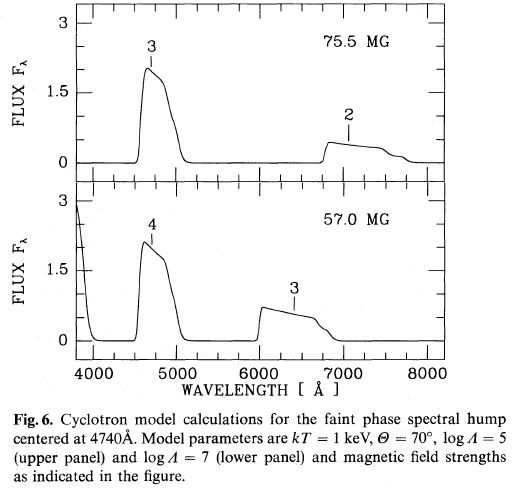

In [43]:
Image(filename='pic/schwope_beuermann_thomas_1990_fig6.jpg')
# https://ui.adsabs.harvard.edu/abs/1990A%26A...230..120S/abstract

In [11]:
# parameters of the top model
kT=1*keV
B=75.5e6
theta=70.*np.pi/180.
loglam=5.
wv=np.arange(3800,8200,10) # wavelength in angstroms
myomega=2*np.pi*c/(wv*1e-8)
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)
# parameters of the bottom model
kT=1*keV
B=57e6
theta=70.*np.pi/180.
loglam=7.
myinten2=ComputeSpec(myomega, kT, B, theta, loglam)

<Figure size 576x576 with 0 Axes>

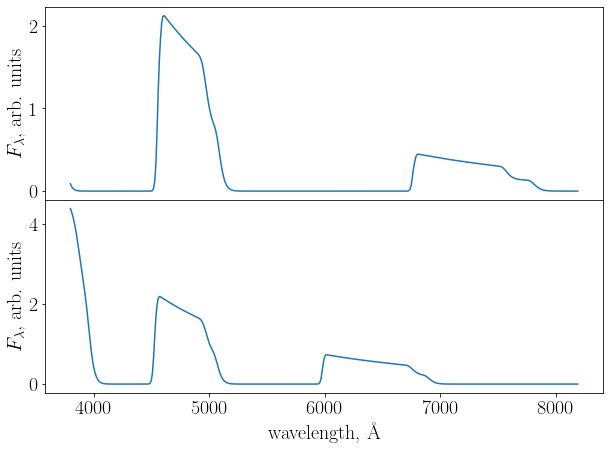

In [12]:
# translating I_omega into F_lambda and plotting:
fig=plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/ganged_plots.html
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
# top panel
axs[0].plot(wv,myinten1*2*np.pi*c/(wv*1e-8)**2*1e-19)
axs[0].set_ylabel(r'$F_{\lambda}$, arb. units')
# bottom panel
axs[1].plot(wv,myinten2*2*np.pi*c/(wv*1e-8)**2*1e-19)
axs[1].set_xlabel(r'wavelength, \AA')
axs[1].set_ylabel(r'$F_{\lambda}$, arb. units')

#fig.tight_layout()
#plt.savefig('reproduction1.png', dpi=300)
plt.show()

<h1>Second test</h1>

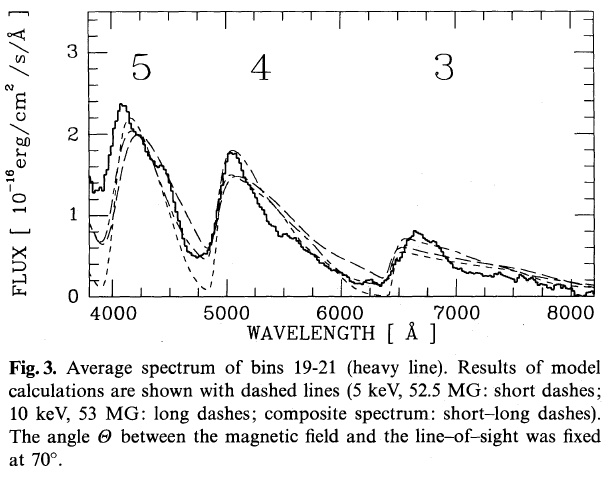

In [44]:
Image(filename='pic/schwope_beuermann_thomas_1990_fig3.jpg')
# https://ui.adsabs.harvard.edu/abs/1990A%26A...230..120S/abstract

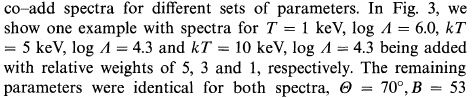

In [46]:
Image(filename='pic/schwope_beuermann_thomas_1990_fig3_comment.jpg')
# https://ui.adsabs.harvard.edu/abs/1990A%26A...230..120S/abstract

In [15]:
# Hm, so the information about this figure is a bit self-inconsistent between the text and the captions...
# short dashes
wv=np.arange(3700,8300,10) # wavelength in angstroms
myomega=2*np.pi*c/(wv*1e-8)
kT=5*keV
B=52.5e6
theta=70.*np.pi/180.
loglam=4.3
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)
# long dashes
kT=10*keV
B=53e6
loglam=4.3
myinten2=ComputeSpec(myomega, kT, B, theta, loglam)
# unclear if shown
kT=1*keV
B=53e6
loglam=6.0
myinten3=ComputeSpec(myomega, kT, B, theta, loglam)

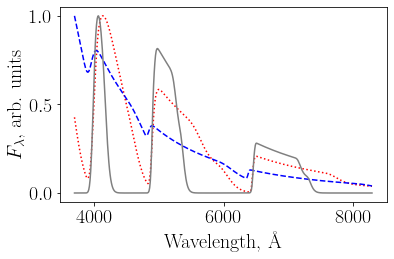

In [16]:
fig=plt.figure(figsize=(6,4))
fig.patch.set_facecolor('white')

flambda1=myinten1*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda1/max(flambda1),color='red', linestyle='dotted')
flambda2=myinten2*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda2/max(flambda2),color='blue', linestyle='dashed')
flambda3=myinten3*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda3/max(flambda3),color='grey')

plt.xlabel(r'Wavelength, \AA')
plt.ylabel(r'$F_{\lambda}$, arb. units')

fig.tight_layout()
plt.show()
# OK, so the 10 keV model doesn't actually quite look right. Mine is a bit too smooth and rises a bit too much
# to the blue... But it's not clear to me that the figure caption accurately reflects which models are being plotted
# because it's not quite consistent with the text... 

<h1>High-temperature test</h1>

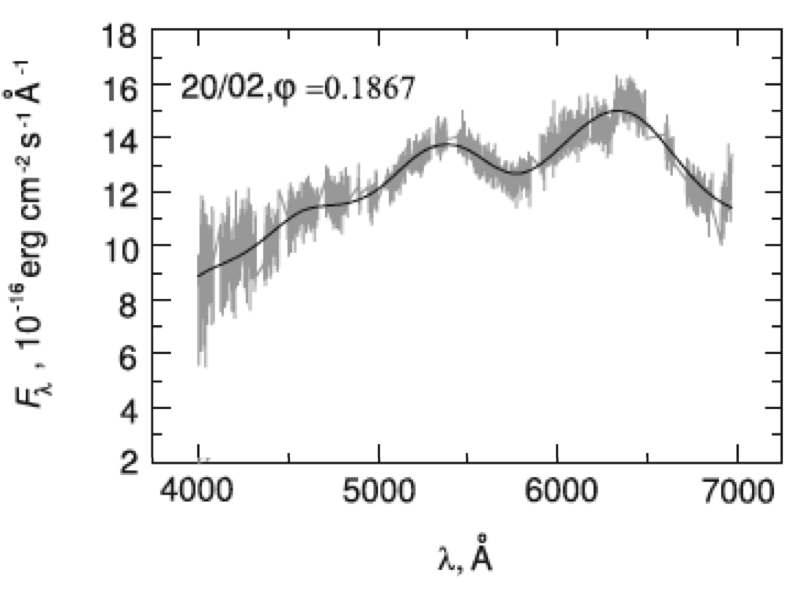

In [47]:
Image(filename='pic/kolbin_2019_fig4.png')
# https://ui.adsabs.harvard.edu/abs/2019AstBu..74...80K/abstract

In [18]:
# parameters are in line 2 of their Table 1
kT=33.*keV
B=39.1e6
theta=79.6*np.pi/180.
loglam=2.16
omega_p=0.0
wv=np.arange(3700,7300,10) # wavelength in angstroms
myomega=2*np.pi*c/(wv*1e-8)
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)

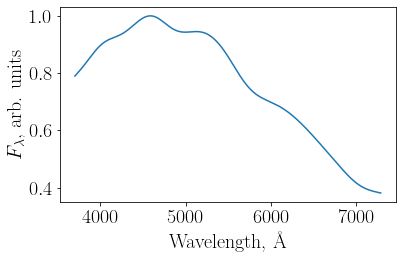

In [19]:
fig=plt.figure(figsize=(6,4))
fig.patch.set_facecolor('white')

flambda1=myinten1*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda1/max(flambda1))

plt.xlabel(r'Wavelength, \AA')
plt.ylabel(r'$F_{\lambda}$, arb. units')

fig.tight_layout()
plt.show()
# I am not super-confident about their models. They used Mahadevan, Narayan and Yi 1996. emissivities which do not 
# propagate + and - modes separately, so I am not sure that these models reproduce well the optically-
# thick regime. In principle, the Mahadevan code is available here: 
# https://rainman.astro.illinois.edu/codelib/codes/harmony/src/, but for the thermal distribution it's only 
# angle-averaged total emissivity, not emissivity in a certain direction which is what we are trying to do here,
# and again I don't see them propagating the modes separately. 

<h1>Temperature test from Schwope et al. 2006 AA 452 955</h1>

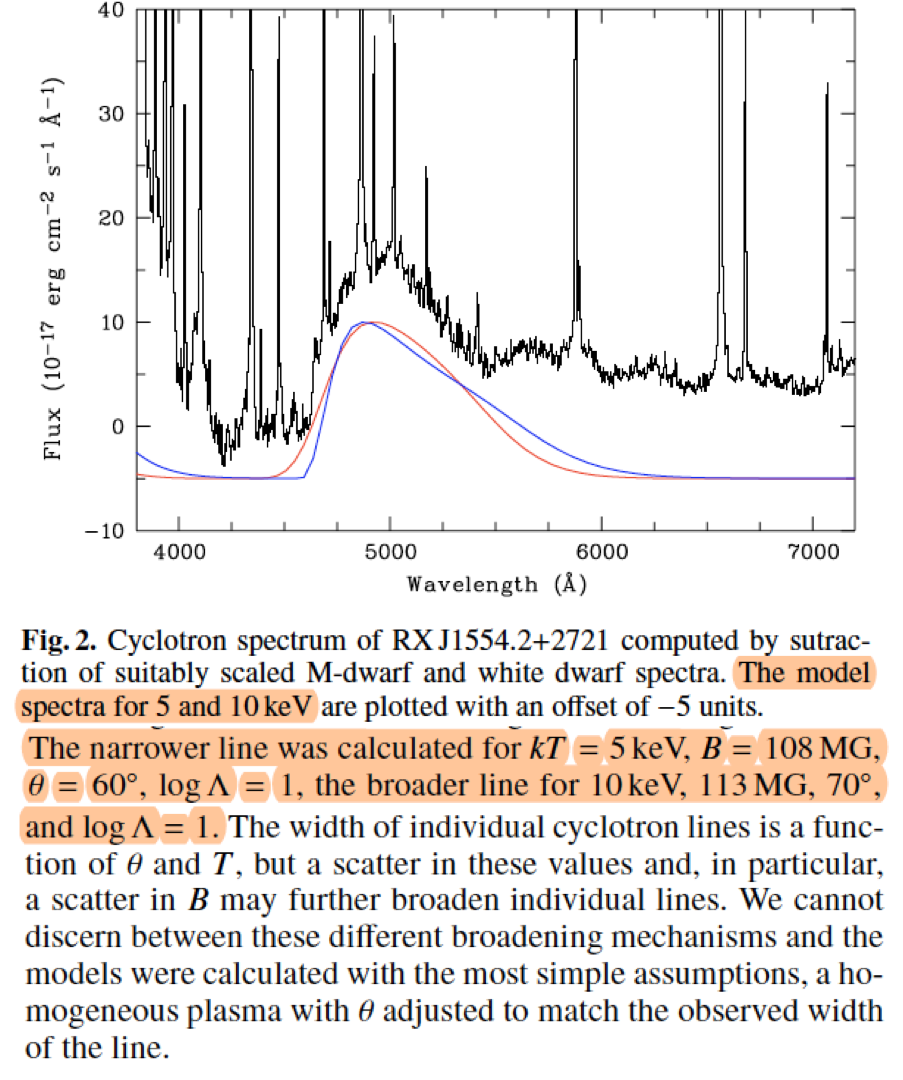

In [48]:
Image(filename='pic/schwope_2006_fig2.png', width=500)
# https://ui.adsabs.harvard.edu/abs/2006A%26A...452..955S/abstract

In [21]:
# it's not actually clear from the picture which one is broader, which one is narrower
wv=np.arange(3700,7300,10) # wavelength in angstroms
myomega=2*np.pi*c/(wv*1e-8)
kT=5*keV
B=108e6
theta=60.*np.pi/180.
loglam=1.
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)
# higher temp
kT=10*keV
B=113e6
theta=70.*np.pi/180.
loglam=1.
myinten2=ComputeSpec(myomega, kT, B, theta, loglam)

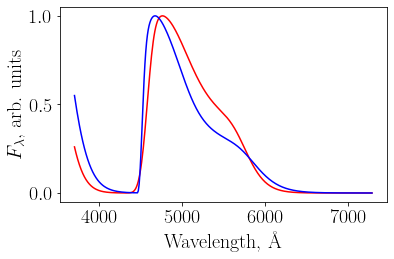

In [22]:
fig=plt.figure(figsize=(6,4))
fig.patch.set_facecolor('white')

flambda1=myinten1*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda1/max(flambda1),color='red')
flambda2=myinten2*2*np.pi*c/(wv*1e-8)**2
plt.plot(wv,flambda2/max(flambda2),color='blue')

plt.xlabel(r'Wavelength, \AA')
plt.ylabel(r'$F_{\lambda}$, arb. units')

fig.tight_layout()
plt.show()
# So clearly despite my generally good agreement with Schwope, there are some discrepancies...

<h1>A test from Harrison and Campbell 2015</h1>

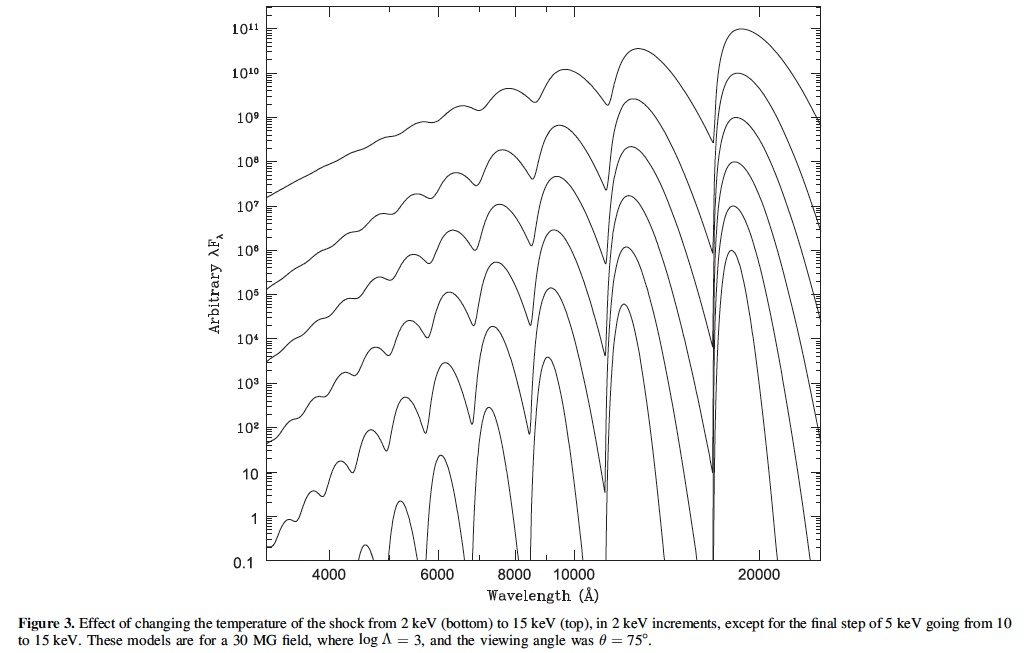

In [49]:
Image(filename='pic/harrison_campbell_2015_fig3.jpg')
# https://ui.adsabs.harvard.edu/abs/2015ApJS..219...32H/abstract

In [24]:
# we'll do a subsample
wv=10**np.linspace(np.log10(3000),np.log10(25000),num=1000) # wavelength in angstroms
myomega=2*np.pi*c/(wv*1e-8)
B=30e6
loglam=3.0
theta=75.*np.pi/180.

kT=2*keV
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)
kT=6*keV
myinten2=ComputeSpec(myomega, kT, B, theta, loglam)
kT=10*keV
myinten3=ComputeSpec(myomega, kT, B, theta, loglam)
kT=15*keV
myinten4=ComputeSpec(myomega, kT, B, theta, loglam)

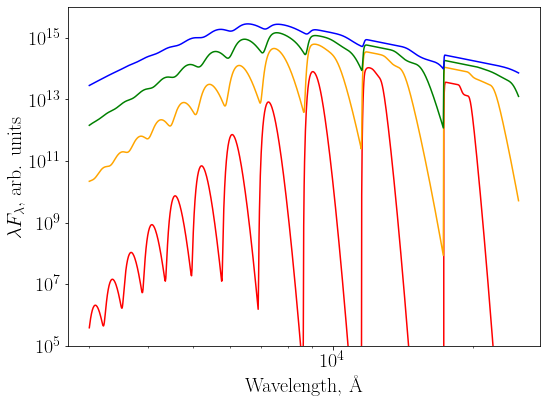

In [25]:
fig=plt.figure(figsize=(8,6))
fig.patch.set_facecolor('white')


plt.plot(wv,myomega*myinten1,color='red')
plt.plot(wv,myomega*myinten2,color='orange')
plt.plot(wv,myomega*myinten3,color='green')
plt.plot(wv,myomega*myinten4,color='blue')

plt.ylim((1e5,1e16))
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Wavelength, \AA')
plt.ylabel(r'$\lambda F_{\lambda}$, arb. units')

fig.tight_layout()
plt.show()
# the overall shape of my models is not the same, but the lack of sub-features in their models is quite alarming.
# the subfeatures / substructures within harmonics quite clearly show up in Schwope papers.
# One red flag about their papers is their insistence in Campbell+ 2008a 
# (https://ui.adsabs.harvard.edu/abs/2008ApJ...672..531C/abstract) that the expressions for omega_p and 
# for omega_c involves relativistic mass, whereas the equations from C&D 1981 very clearly have rest mass. 

<h1>Finally, let's see how this applies to Liu, Hwang, Zakamska, Thonstensen 2022 cataclismic variable</h1>
<a href="https://ui.adsabs.harvard.edu/abs/2022arXiv221114945L/abstract">CSS1603+19: a low-mass polar near the cataclysmic variable period minimum</a>

In [27]:
# calculation of the values of n and B from the observed features
lamnp=21400*1e-8
lamn=23900*1e-8
n=lamnp/(lamn-lamnp)
# assume lower n
B1=2*np.pi*me*c**2/(qe*lamn*int(n))
# assume higher n
B2=2*np.pi*me*c**2/(qe*lamn*(int(n)+1.))
print(int(n),'{:.2e}'.format(B1),int(n)+1,'{:.2e}'.format(B2))

8 5.61e+06 9 4.98e+06


In [34]:
# wavelength array
wv=10**np.linspace(np.log10(1.),np.log10(8.),num=500) # wavelength in microns
# frequency array
myomega=2*np.pi*c/(wv*1e-4)
# a couple of models with different parameters, but fixed locations of the peaks
B=5.61e6
loglam=1.0
theta=50.*np.pi/180.
kT=1*keV
myinten1=ComputeSpec(myomega, kT, B, theta, loglam)
# another model
B=6.6e6
loglam=4.0
theta=70.*np.pi/180.
kT=5*keV
myinten2=ComputeSpec(myomega, kT, B, theta, loglam)

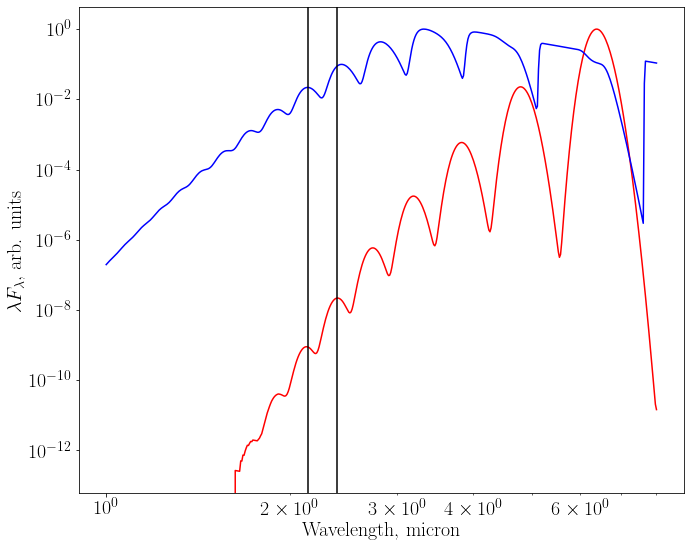

In [35]:
fig=plt.figure(figsize=(10,8))
fig.patch.set_facecolor('white')

plt.plot(wv,myomega*myinten1/max(myomega*myinten1),color='red')
plt.plot(wv,myomega*myinten2/max(myomega*myinten2),color='blue')
plt.axvline(x = 2.14, color = 'black')
plt.axvline(x = 2.39, color = 'black')

#plt.ylim((1e5,1e16))
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Wavelength, micron')
plt.ylabel(r'$\lambda F_{\lambda}$, arb. units')

fig.tight_layout()
plt.show()